Import Libraries

In [12]:
# helps make code more compatible between Python 2 and Python 3
from __future__ import absolute_import, division, print_function
# allows for copying or deleting directories in bulk
from distutils.dir_util import copy_tree, remove_tree

# ensures that matplotlib plots are disdplayed inside the notebook 
%matplotlib inline

# provides access to system-specific parameters and functions
import sys
# helps with file and directory operations, enviornment variables, and process control
import os
# for image loading, processing, and manipulation
import cv2
import shutil

import matplotlib # for plotting and visualiztion
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import axes3d # for creating 3D plots
from tqdm import tqdm # library used for displaying progress bars for loops
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model, image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from random import randint

print("Version information")

print("python: {}".format(sys.version))
print("matplotlib: {}".format(matplotlib.__version__))
print("numpy: {}".format(np.__version__))
print("current working directory:", os.getcwd()) # prints curr working directory
print("list of files:", os.listdir())  # Lists the files in the current directory
print("cv2 version:", cv2.__version__)

# Load image
import imageio

# automatically reloads modules before executing code
%load_ext autoreload
%autoreload 2

Version information
python: 3.11.5 (main, Sep 11 2023, 08:17:37) [Clang 14.0.6 ]
matplotlib: 3.9.2
numpy: 1.23.5
current working directory: /Users/erin/Library/Mobile Documents/com~apple~CloudDocs/1_gt/2_gatechJunior/Fall24/CS4641/Alzheimer-Detection/notebooks
list of files: ['2_Model_2.ipynb', '1_CNN.ipynb', 'data_split', '3_Model_3.ipynb']
cv2 version: 4.6.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


directory setup and split data

In [11]:
# define path to data
data_dir = "../data/"
# split data
split_dir = "../data_split" # where split data will go
# create split directory
os.makedirs(split_dir, exist_ok=True)

train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

classes = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']

# create subdirectories 
for split in ['train', 'validation', 'test']:
    split_path = os.path.join(split_dir, split)
    os.makedirs(split_path, exist_ok=True)
    for cls in classes:
        cls_path = os.path.join(split_path, cls)
        os.makedirs(cls_path, exist_ok=True)

# to split and copy files
def split_data(class_name, src_dir, train_ratio, test_ratio, val_ratio):
    class_dir = os.path.join(src_dir, class_name)
    images = os.listdir(class_dir)

    # train test validation split
    train_images, test_images =  train_test_split(images, test_size=(test_ratio + val_ratio))
    val_images, test_images = train_test_split(test_images, test_size=(test_ratio / (test_ratio + val_ratio)))

    # copy images to folders
    for image in train_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(split_dir, 'train', class_name, image))

    for image in val_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(split_dir, 'validation', class_name, image))

    for image in test_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(split_dir, 'test', class_name, image))

for cls in classes:
    split_data(cls, data_dir, train_ratio, test_ratio, val_ratio)

print("data has been split")
print("working directory contents:", os.listdir(split_dir))

data has been split
working directory contents: ['test', 'train', 'validation']


preprocessing data -- data augmentation & normalization

In [16]:
IMG_SIZE = 176 # resize images to 176 x 176
BRIGHT_RANGE = [0.8, 1.2] # adjust brightness to 80 - 120% of original
ZOOM = [0.99, 1.01] # range of zoom -- 1% in or out
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

# imagedatagenerators
# rescale: normalizes pixel values by dividing by 255 --> bring values in range [0, 1]
# brightness_range: randomly adjusts brightness within specified range 
# zoom_range: randomly zoomes in/out within specifed range
# horizontal_flip: randomly flips images horizontally for more variety
# want augmentation in training data but not test/validation --> just rescale
train_image_generator = ImageDataGenerator(rescale = 1./255, brightness_range = BRIGHT_RANGE, zoom_range = ZOOM, data_format = DATA_FORMAT, fill_mode = FILL_MODE, horizontal_flip = True)

validation_image_generator = ImageDataGenerator(rescale = 1./255)

test_image_generator = ImageDataGenerator(rescale = 1./255)

# each batch has 32 images
print("train images - 70%")
train_dataset = train_image_generator.flow_from_directory(batch_size = 32, directory = os.path.join(split_dir, 'train'), target_size = (176, 176), shuffle = True)

print("test images - 20%")
test_dataset = test_image_generator.flow_from_directory(batch_size = 32, directory = os.path.join(split_dir, 'test'), target_size = (176, 176), shuffle = False)

print("validation images - 10%")
validation_dataset = validation_image_generator.flow_from_directory(batch_size = 32, directory = os.path.join(split_dir, 'validation'), target_size = (176, 176), shuffle = False)


train images - 70%
Found 78569 images belonging to 4 classes.
test images - 20%
Found 31055 images belonging to 4 classes.
validation images - 10%
Found 16388 images belonging to 4 classes.


Visualize batch of images from dataset 

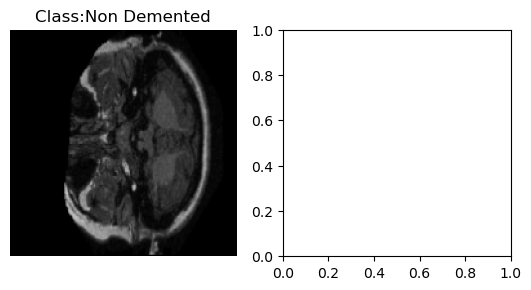

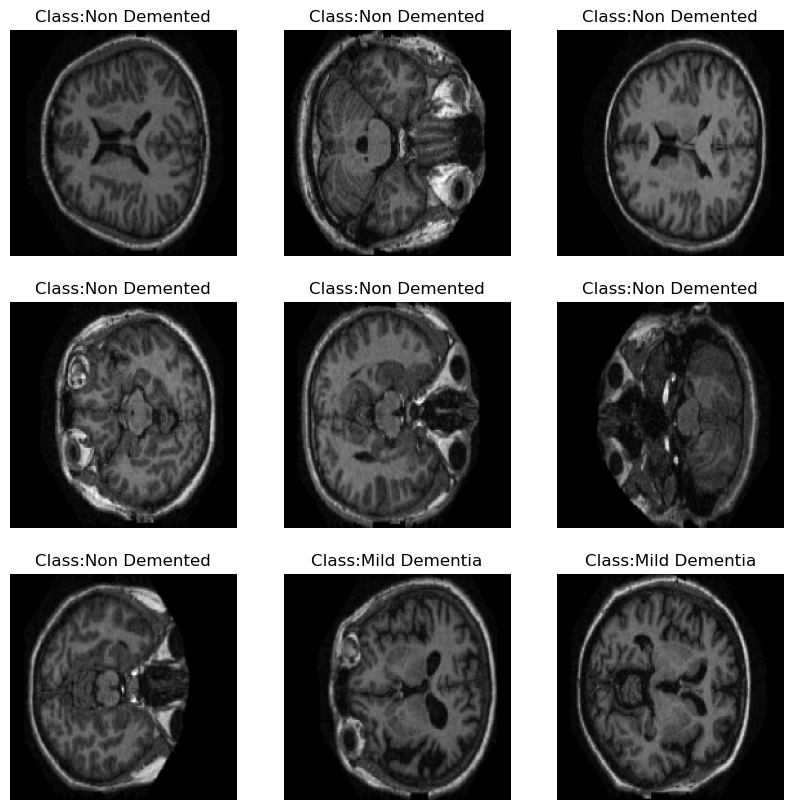

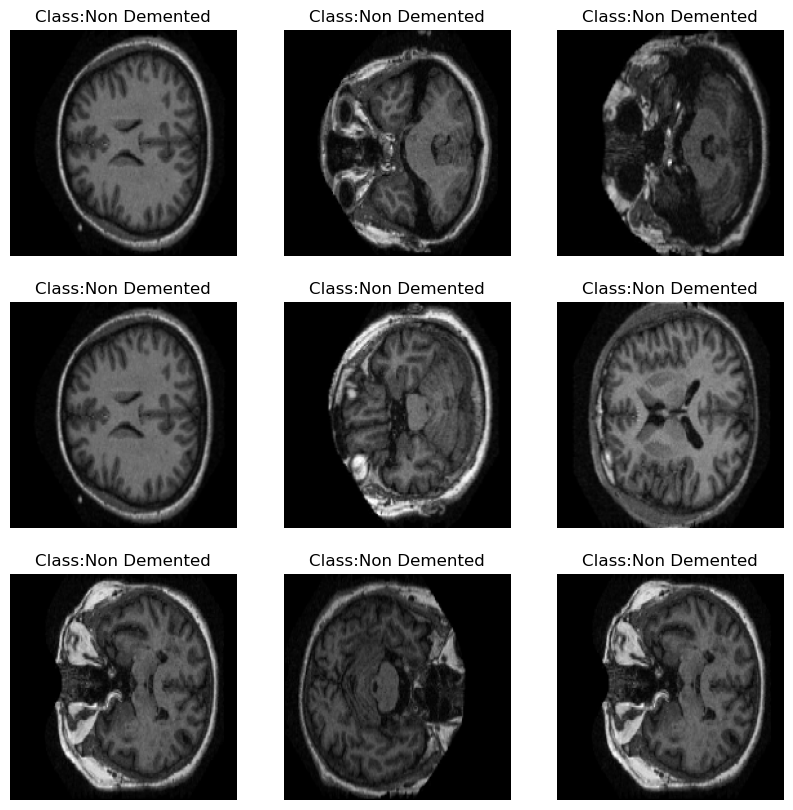

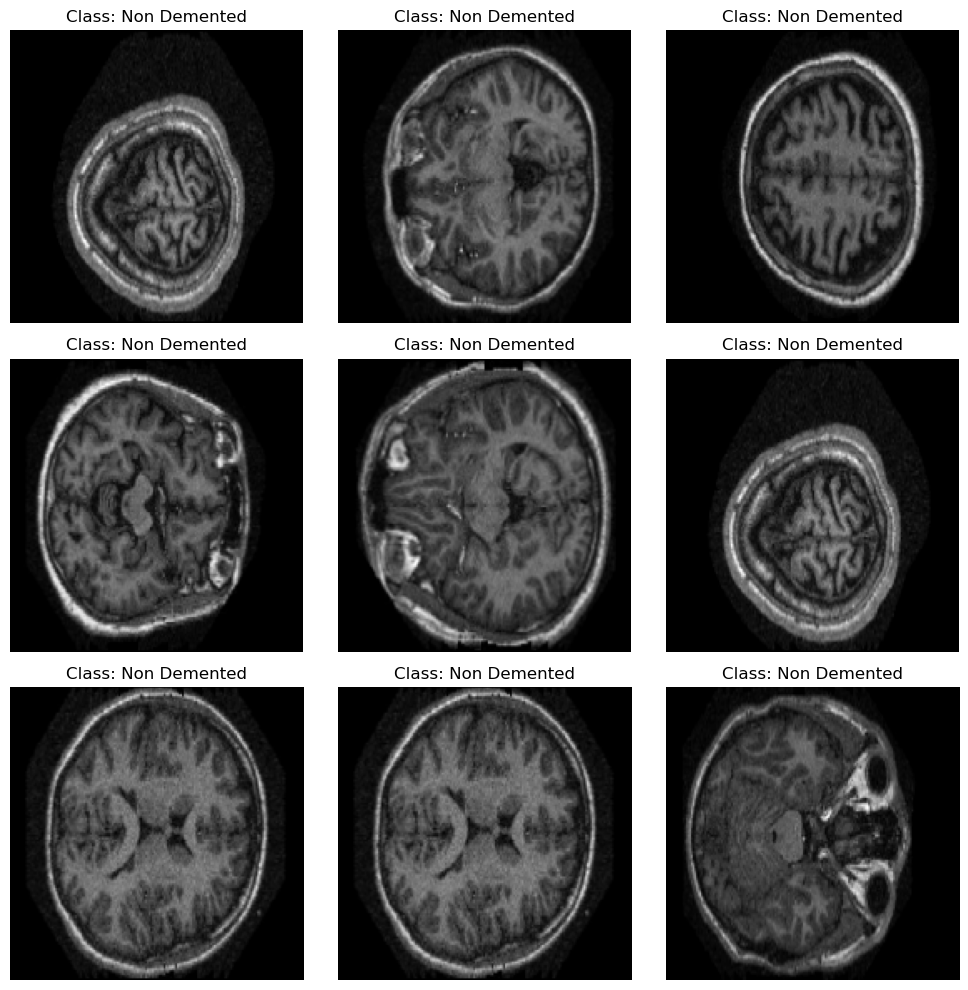

In [20]:
def image_sample_visualization(generator, y_pred = None):
    labels = dict(zip([0, 1, 2, 3], classes))

    # get batch of images and labels
    x, y = generator.next()

    # display grid of 9 images
    plt.figure(figsize = (10, 10))
    if y_pred is None:
        # display actually class labels for 9 random iamges
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            index = randint(0, len(x) - 1) #randomly select an index within the batch size
            img = x[index]

            # rescale image for display if needed
            if img.max() <= 1:
                img = (img * 255).astype(np.uint8)

            # show image
            plt.imshow(img)
            plt.axis("off")
            plt.title("Class: {}".format(labels[np.argmax(y[index])]))
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            img = x[i]

            # rescale image for display if needed
            if img.max() <= 1:
                img = (img * 255).astype(np.uint8)

            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])], labels[y_pred[i]]))

    plt.tight_layout()
    plt.show()

image_sample_visualization(train_dataset)